In [62]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# ------------------------------
# 1. Parameter Setup (Calibrated)
# ------------------------------
a = 0.13       # Example mean-reversion speed
b = 3.06/100       # Example long-run mean
sigma = 0.98/100   # Example volatility
r0 = 0.987200022/100     # Example initial short rate

In [41]:
df = pd.read_excel('case_study_data.xlsx', sheet_name=1)

In [42]:
df.columns = df.iloc[0]
df.columns
index = df['Maturity (years)'][2:]
index.name = 'Date'
df = df[2:]
df.index = index
df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


,Maturity (years),0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-31,2014-10-31 00:00:00,0.001525,0.001525,0.005385,0.009872,0.013707,0.016728,0.019069,0.020903,0.022370,...,0.030328,0.030618,0.030887,0.031137,0.031370,0.031587,0.031791,0.031981,0.032160,0.032327
2014-11-03,2014-11-03 00:00:00,0.001631,0.001631,0.005533,0.010066,0.013901,0.016893,0.019199,0.020998,0.022437,...,0.030274,0.030560,0.030825,0.031071,0.031299,0.031513,0.031712,0.031899,0.032074,0.032238
2014-11-04,2014-11-04 00:00:00,0.001439,0.001439,0.005512,0.010062,0.013873,0.016836,0.019115,0.020892,0.022312,...,0.030027,0.030307,0.030566,0.030807,0.031032,0.031241,0.031436,0.031619,0.031790,0.031951
2014-11-05,2014-11-05 00:00:00,0.001556,0.001556,0.005611,0.010135,0.013922,0.016873,0.019152,0.020938,0.022374,...,0.030160,0.030433,0.030685,0.030918,0.031135,0.031335,0.031523,0.031697,0.031860,0.032013
2014-11-06,2014-11-06 00:00:00,0.001682,0.001682,0.005814,0.010413,0.014241,0.017211,0.019498,0.021290,0.022729,...,0.030549,0.030822,0.031074,0.031307,0.031523,0.031723,0.031910,0.032084,0.032246,0.032398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,2024-10-28 00:00:00,0.042701,0.042701,0.040979,0.040501,0.040558,0.040855,0.041258,0.041703,0.042157,...,0.046125,0.046271,0.046398,0.046509,0.046604,0.046683,0.046749,0.046801,0.046841,0.046870
2024-10-29,2024-10-29 00:00:00,0.042583,0.042583,0.040861,0.040406,0.040491,0.040813,0.041238,0.041702,0.042171,...,0.046145,0.046283,0.046402,0.046503,0.046588,0.046658,0.046713,0.046755,0.046785,0.046803
2024-10-30,2024-10-30 00:00:00,0.042760,0.042760,0.041321,0.040869,0.040888,0.041134,0.041487,0.041885,0.042296,...,0.045830,0.045949,0.046051,0.046138,0.046209,0.046267,0.046311,0.046343,0.046364,0.046374


In [43]:
# ------------------------------
# 2. Date Ranges
# ------------------------------


dates = df.index
N = len(dates)

# day_count convention (simple 1/365)
dt = 1.0/365.0

In [44]:
# ------------------------------
# 3. Simulate Short-Rate Path
# ------------------------------
r = np.zeros(N)
r[0] = r0

# Euler-Maruyama discretization for Vasicek:
# dr_t = a(b - r_t)*dt + sigma * sqrt(dt)*Z,  Z ~ N(0,1)
for i in range(1, N):
    z = np.random.randn()
    dr = a*(b - r[i-1])*dt + sigma*np.sqrt(dt)*z
    r[i] = r[i-1] + dr

In [45]:

# ------------------------------
# 4. Function for Vasicek ZCB Price
# ------------------------------
def vasicek_zcb_price(r_t, tau, a, b, sigma):
    """
    Returns price P(t, t+tau) of a zero-coupon bond
    under the Vasicek model, given:
      r_t : short rate at time t
      tau : time to maturity in years
      a,b,sigma : Vasicek parameters
    """
    # B(t,T) = (1 - e^{-a(T - t)}) / a
    B = (1.0 - np.exp(-a*tau)) / a
    
    # A(t,T) = b[B - tau] - (sigma^2/(4a)) * B^2
    #        + possible - (sigma^2/(2a^2)) * ...
    # The more standard closed-form is:
    #   A = ( b - sigma^2/(2a^2) ) * (B - tau) 
    #       - (sigma^2/(4a)) * B^2
    # but we can directly plug in the known formula:
    
    term1 = (b - (sigma**2)/(2.0*a**2))*(B - tau)
    term2 = (sigma**2)/(4.0*a) * B**2
    A = term1 - term2
    
    return np.exp(-A - B*r_t)

In [46]:

# ------------------------------
# 5. Compute the 3-Year Bond Index
# ------------------------------
maturity = 3.0  # constant 3-year maturity
bond_prices = np.zeros(N)

for i in range(N):
    bond_prices[i] = vasicek_zcb_price(r[i], 
                                       maturity, 
                                       a, b, sigma)


In [53]:

# ------------------------------
# 6. Create a DataFrame for Output
# ------------------------------
df_bond = pd.DataFrame({
    'Date': dates,
    'Short_Rate': r,
    'ZCB_3yr': bond_prices
})

# Optionally, set 'Date' as the DataFrame index
df_bond.set_index('Date', inplace=True)

In [60]:
df_bond['bond_return'] = df_bond['ZCB_3yr'].pct_change()

In [61]:
df_bond

,Short_Rate,ZCB_3yr,bond_return
Date,,,
2014-10-31,0.009872,0.990975,NaN
2014-11-03,0.010322,0.989869,-0.001116
2014-11-04,0.010616,0.989146,-0.000731
2014-11-05,0.010631,0.989109,-0.000037
2014-11-06,0.010501,0.989428,0.000322
...,...,...,...
2024-10-28,0.016444,0.974927,0.001141
2024-10-29,0.016009,0.975983,0.001083
2024-10-30,0.016470,0.974865,-0.001145


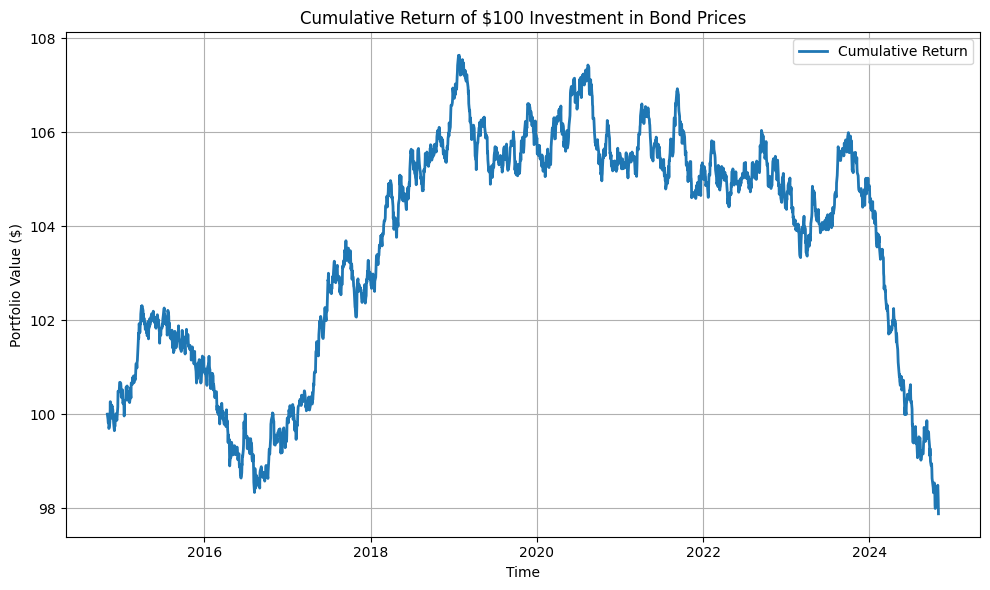

In [64]:


# Calculate cumulative return starting with $100
initial_investment = 100
cumulative_return = initial_investment * (1 + df_bond['bond_return'].fillna(0)).cumprod()

# Plotting the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(cumulative_return, label='Cumulative Return', linewidth=2)
plt.title('Cumulative Return of $100 Investment in Bond Prices')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
# Precompute B(T-t)
def B(t, T, a):
    return (1 - np.exp(-a * (T - t))) / a

In [187]:
# Function to calculate A(t, T) using the provided B(t, T)
def A_vasicek_with_B(t, T, a, b, sigma):
    """
    Calculate the A(t, T) component using the given B(t, T) function in the Vasicek bond pricing formula.

    Parameters:
    - t: Current time
    - T: Maturity time of the bond
    - a: Speed of mean reversion
    - b: Long-term mean interest rate
    - sigma: Volatility of the short rate

    Returns:
    - A(t, T)
    """
    B_value = B(t, T, a)
    
    # Formula for A(t, T)
    A = (b - (sigma ** 2) / (2 * a ** 2)) * (B_value - (T - t)) - (sigma ** 2) * B_value ** 2 / (4 * a)
    
    return A

In [157]:
def simulate_and_store_paths(M, N, a, b, sigma, r0, T, dt):
    """
    Simulate and store short rate and bond return paths under the Vasicek model.

    Parameters:
        M (int): Number of simulation paths.
        N (int): Number of time steps.
        a (float): Speed of mean reversion.
        b (float): Long-term mean interest rate.
        sigma (float): Volatility of interest rate.
        r0 (float): Initial short rate.
        T (float): Bond maturity in years.
        dt (float): Time step size.

    Returns:
        r_paths (ndarray): Simulated short rate paths (M x N).
        bond_return_paths (ndarray): Simulated bond return paths (M x N).
    """

    r_paths = np.zeros((M, N))
    bond_return_paths = np.zeros((M, N))
    
    for i in range(M):
        r = np.zeros(N)
        bond_return = np.zeros(N)
        r[0] = r0
        bond_return[0] = 1  # Start with a normalized value of 1
        dW = np.random.normal(0, np.sqrt(dt), N-1)  # Shared Brownian motion

        # Simulate short rate and bond return paths
        for j in range(1, N):
            dr = a * (b - r[j-1]) * dt + sigma * dW[j-1]
            r[j] = r[j-1] + dr
            BtT = B(j * dt, T+j*dt, a) # tT = 3
            bond_return[j] = bond_return[j-1] * np.exp(r[j-1] * dt - BtT * sigma * dW[j-1])

        r_paths[i, :] = r
        bond_return_paths[i, :] = bond_return

    return r_paths, bond_return_paths

In [204]:
# Function to calculate the bond price under the Vasicek model
def vasicek_bond_price(t, T, r_t, a, b, sigma):
    B = (1 - np.exp(-a * (T - t))) / a
    A = (b - (sigma ** 2) / (2 * a ** 2)) * (B - (T - t)) - (sigma ** 2) * B ** 2 / (4 * a)
    return np.exp(A - B * r_t)

# Updated function to simulate short rate, bond return, and cumulative return
def simulate_and_store_paths(M, N, a, b, sigma, r0, T, dt):
    """
    Simulate short rate paths, bond returns, and cumulative returns under the Vasicek model.

    Parameters:
        M (int): Number of simulation paths.
        N (int): Number of time steps.
        a (float): Speed of mean reversion.
        b (float): Long-term mean interest rate.
        sigma (float): Volatility of interest rate.
        r0 (float): Initial short rate.
        T (float): Bond maturity in years.
        dt (float): Time step size.

    Returns:
        r_paths (ndarray): Simulated short rate paths (M x N).
        bond_return_paths (ndarray): Bond returns at each step (M x N).
        cumulative_return_paths (ndarray): Cumulative returns (M x N) starting from 1.
    """
    r_paths = np.zeros((M, N))
    bond_prices_paths = np.zeros((M,N))
    bond_return_paths = np.zeros((M, N))
    cumulative_return_paths = np.ones((M, N))  # Start with 1 for initial investment

    for i in range(M):
        r = np.zeros(N)
        bond_prices = np.zeros(N)
        bond_return = np.zeros(N)
        cumulative_return = np.ones(N)
        r[0] = r0
        bond_prices[0] = vasicek_bond_price(0, T, r0, a, b, sigma)

        # Simulate short rate and calculate bond returns
        for j in range(1, N):
            dW = np.random.normal(0, np.sqrt(dt))  # Shared Brownian motion
            dr = a * (b - r[j - 1]) * dt + sigma * dW
            r[j] = r[j - 1] + dr

            # Calculate bond prices at time t 
            bond_prices[j] = vasicek_bond_price(j * dt, T + j * dt, r[j], a, b, sigma)

            # Calculate bond return based on price ratio
            bond_return[j] = (bond_prices[j] / bond_prices[j-1]) - 1

            # Calculate cumulative return
            cumulative_return[j] = cumulative_return[j - 1] * (1 + bond_return[j])

        # Store paths
        r_paths[i, :] = r
        bond_prices_paths[i,:] = bond_prices
        bond_return_paths[i, :] = bond_return
        cumulative_return_paths[i, :] = cumulative_return

    return r_paths, bond_prices_paths, bond_return_paths, cumulative_return_paths

In [206]:
# Simulate and store both the bond return path and the short rate path
# ------------------------------
# 1. Parameter Setup (Calibrated)
# ------------------------------
a = 0.13       # Example mean-reversion speed
b = 3.06/100       # Example long-run mean
sigma = 0.98/100   # Example volatility
r0 = 0.987200022/100     # Example initial short rate
dates = df.index
N = len(dates)
# day_count convention (simple 1/365)
dt = 1.0/365.0
T=3


M=10

# Generate and store the paths
r_paths, bond_prices_paths, bond_return_paths,cumulative_return_paths = simulate_and_store_paths(M=M, N=N, a=a, b=b, sigma=sigma, r0=r0, T=T, dt=dt)





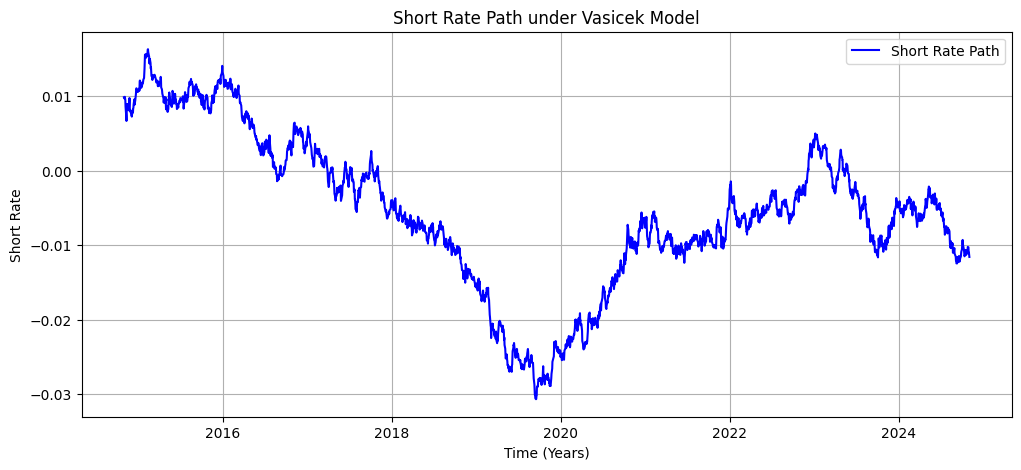

In [207]:
plt.figure(figsize=(12, 5))

# Plot the short rate path
plt.plot(dates, r_paths[0], label='Short Rate Path', color='blue')
plt.title("Short Rate Path under Vasicek Model")
plt.xlabel("Time (Years)")
plt.ylabel("Short Rate")
plt.grid(True)
plt.legend()
plt.show()

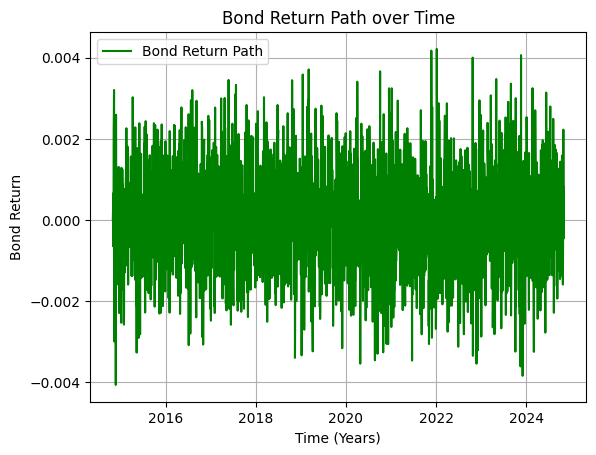

In [208]:
# Plot the bond return path
plt.plot(dates, bond_return_paths[0], label='Bond Return Path', color='green')
plt.title("Bond Return Path over Time")
plt.xlabel("Time (Years)")
plt.ylabel("Bond Return")
plt.grid(True)
plt.legend()
plt.show()


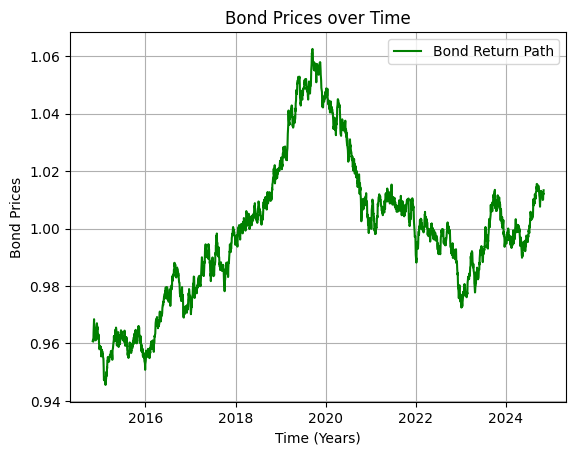

In [210]:
# Plot the bond return path
plt.plot(dates, bond_prices_paths[0], label='Bond Return Path', color='green')
plt.title("Bond Prices over Time")
plt.xlabel("Time (Years)")
plt.ylabel("Bond Prices")
plt.grid(True)
plt.legend()
plt.show()

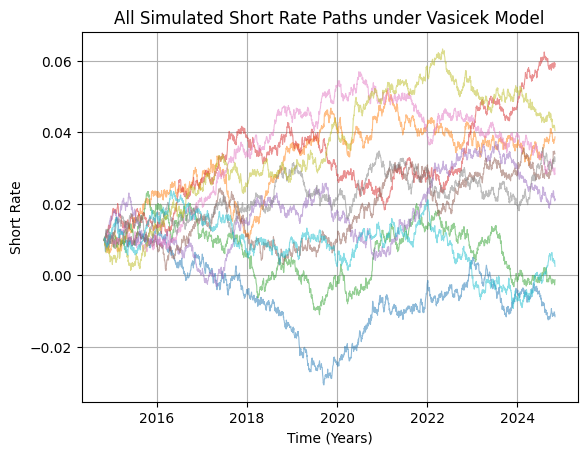

In [211]:
for i in range(M):
    plt.plot(dates, r_paths[i], alpha=0.5,linewidth = 0.8)
plt.title("All Simulated Short Rate Paths under Vasicek Model")
plt.xlabel("Time (Years)")
plt.ylabel("Short Rate")
plt.grid(True)

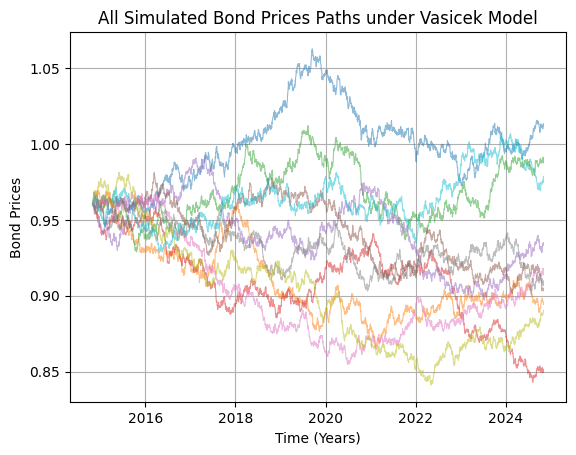

In [213]:
for i in range(M):
    plt.plot(dates, bond_prices_paths[i], alpha=0.5,linewidth = 0.8)
plt.title("All Simulated Bond Prices Paths under Vasicek Model")
plt.xlabel("Time (Years)")
plt.ylabel("Bond Prices")
plt.grid(True)

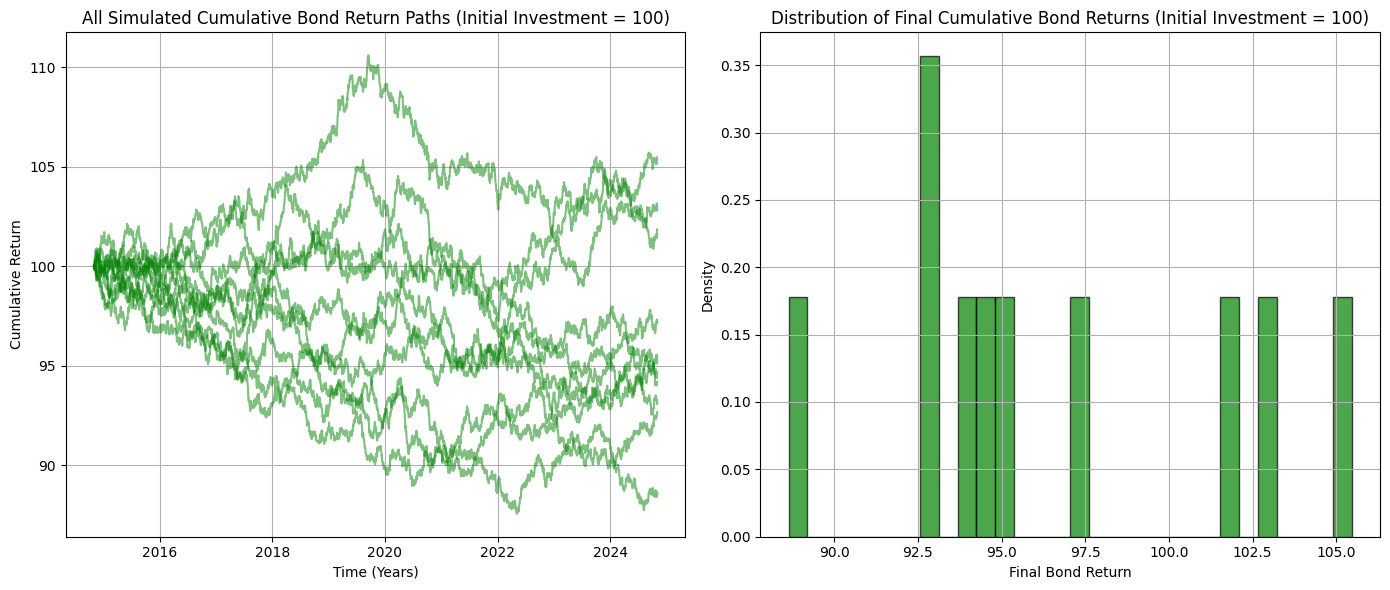

In [212]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot all cumulative bond return paths with initial investment = 100
for i in range(M):
    axes[0].plot(dates, cumulative_return_paths[i]*initial_investment, color='green', alpha=0.5)

axes[0].set_title("All Simulated Cumulative Bond Return Paths (Initial Investment = 100)")
axes[0].set_xlabel("Time (Years)")
axes[0].set_ylabel("Cumulative Return")
axes[0].grid(True)

# Plot the distribution of final cumulative bond returns
final_returns = cumulative_return_paths[:, -1] * initial_investment  # Final cumulative returns
axes[1].hist(final_returns, bins=30, density=True, color='green', alpha=0.7, edgecolor='black')

axes[1].set_title("Distribution of Final Cumulative Bond Returns (Initial Investment = 100)")
axes[1].set_xlabel("Final Bond Return")
axes[1].set_ylabel("Density")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [180]:
sum(final_returns<100)

1

In [214]:

# Generate descriptive statistics
summary_statistics = {
    'Mean': np.mean(final_returns),
    'Median': np.median(final_returns),
    'Standard Deviation': np.std(final_returns),
    'Minimum': np.min(final_returns),
    'Maximum': np.max(final_returns),
    '25th Percentile (Q1)': np.percentile(final_returns, 25),
    '75th Percentile (Q3)': np.percentile(final_returns, 75),
    'Skewness': pd.Series(final_returns).skew(),
    'Kurtosis': pd.Series(final_returns).kurtosis()
}

# Convert to DataFrame for better presentation
summary_df = pd.DataFrame(summary_statistics, index=["Final Cumulative Return Statistics"]).T

print(summary_df)

                      Final Cumulative Return Statistics
Mean                                           96.568751
Median                                         94.901039
Standard Deviation                              4.976592
Minimum                                        88.638189
Maximum                                       105.466969
25th Percentile (Q1)                           93.355271
75th Percentile (Q3)                          100.684884
Skewness                                        0.450808
Kurtosis                                       -0.614852


In [224]:
bond_return_paths

array([[ 0.00000000e+00,  5.01648532e-04, -6.50298250e-04, ...,
        -4.53789210e-04,  6.35436239e-04,  8.01554631e-04],
       [ 0.00000000e+00,  1.20136156e-03,  2.08115618e-04, ...,
        -4.27673336e-04, -1.37068991e-03, -2.79795624e-04],
       [ 0.00000000e+00, -1.12577966e-03,  2.07190879e-05, ...,
        -8.58087177e-04, -1.78736648e-03, -9.87459517e-04],
       ...,
       [ 0.00000000e+00, -1.64195066e-03,  1.00706542e-03, ...,
         6.60342341e-04,  5.05374657e-04,  2.12745996e-03],
       [ 0.00000000e+00, -1.05782484e-03,  5.41717450e-04, ...,
         1.15404474e-03,  1.08367394e-03,  3.24712430e-04],
       [ 0.00000000e+00, -1.54304425e-03,  4.42159224e-04, ...,
         1.87481803e-03,  1.91052557e-03,  2.82883513e-04]])

In [227]:
# Convert the array to a DataFrame and assign the existing date index
returns_df = pd.DataFrame(bond_return_paths.T, index=dates)

# Optional: Rename columns for clarity
returns_df.columns = [f'Path_{i+1}' for i in range(bond_return_paths.shape[0])]

# Display the first few rows
returns_df


,Path_1,Path_2,Path_3,Path_4,Path_5,Path_6,Path_7,Path_8,Path_9,Path_10
Date,,,,,,,,,,
2014-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-11-03,0.000502,0.001201,-0.001126,0.000427,-0.000043,-0.001301,0.001016,-0.001642,-0.001058,-0.001543
2014-11-04,-0.000650,0.000208,0.000021,-0.001605,0.001089,0.000927,-0.000464,0.001007,0.000542,0.000442
2014-11-05,0.000665,0.001235,-0.000074,0.001314,-0.001268,0.000601,0.000477,-0.001311,0.001154,0.002267
2014-11-06,0.000385,0.000341,-0.001032,-0.000728,-0.001080,0.000271,0.001665,0.002044,0.003416,0.000762
...,...,...,...,...,...,...,...,...,...,...
2024-10-28,0.000127,-0.000999,0.001049,0.001528,0.000118,-0.000799,0.000004,0.000966,0.000059,-0.001136
2024-10-29,0.002227,0.000120,0.001261,0.000272,-0.000726,0.000930,-0.001099,-0.001738,0.000444,-0.000570
2024-10-30,-0.000454,-0.000428,-0.000858,-0.000778,0.001924,0.000688,0.001254,0.000660,0.001154,0.001875


In [228]:
# Function to calculate the Present Value (PV) of an annuity with separate discount rates
def annuity_present_value_separate_rates(discount_rates, payment_series):
    """
    Calculate the Present Value (PV) of an annuity with distinct discount rates.

    Parameters:
    - discount_rates: Daily discount rate series (Pandas Series with DateTimeIndex).
    - payment_series: Monthly payment series (Pandas Series with DateTimeIndex, payment = 1 at month-end).

    Returns:
    - PV: Present Value of the annuity.
    """
    # Align the discount rates with payment dates
    aligned_discount_rates = discount_rates.loc[payment_series.index]
    
    # Compute the cumulative discount factor
    discount_factors = (1 + aligned_discount_rates).cumprod()
    
    # Present Value calculation
    PV = (payment_series / discount_factors).sum()
    
    return PV

In [263]:
def annuity_future_value_separate_rates(return_rates, payment_series):
    """
    Calculate the Future Value (FV) of an annuity with distinct return rates.

    Parameters:
    - return_rates: Daily return rate series (Pandas Series with DateTimeIndex).
    - payment_series: Monthly payment series (Pandas Series with DateTimeIndex, payment = 1 at month-end).

    Returns:
    - FV: Future Value of the annuity.
    """
    
    
    # Compute compounding factors for each payment
    aligned_return_rates = (1 + return_rates[::-1]).cumprod()[::-1]
    print(aligned_return_rates)
    # Align the return rates with payment dates
    compounding_factors = aligned_return_rates.loc[payment_series.index]
    
    # Future Value calculation
    FV = (payment_series * compounding_factors).sum()
    
    return FV


In [258]:

aligned_return_rates = returns_df.loc[cash_flow_df.index]
aligned_return_rates

,Path_1,Path_2,Path_3,Path_4,Path_5,Path_6,Path_7,Path_8,Path_9,Path_10
2014-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-11-28,-0.000289,0.000825,-0.002054,0.000631,-0.002491,-0.000024,0.002050,-0.000031,-0.000017,0.000529
2014-12-31,0.000522,-0.000078,0.000867,0.000906,-0.000290,0.000134,0.000054,-0.000689,0.002002,-0.000413
2015-01-30,-0.002157,0.002074,-0.000396,0.001284,0.002803,0.000764,0.000301,-0.002340,0.000266,-0.000435
2015-02-27,0.001043,-0.000213,-0.003234,-0.000859,-0.001303,-0.000761,0.000600,-0.000038,-0.001579,-0.000259
...,...,...,...,...,...,...,...,...,...,...
2024-07-31,-0.001360,0.000436,0.000242,0.000163,-0.000058,0.000254,-0.000024,0.000958,-0.000350,-0.001613
2024-08-30,0.000301,0.001363,0.001792,0.000552,0.001502,0.001545,0.000211,0.000082,0.000319,-0.000654
2024-09-30,-0.000858,-0.001703,0.001153,-0.001854,-0.001751,-0.000479,-0.000059,0.000973,0.001860,-0.000684
2024-10-31,0.000635,-0.001371,-0.001787,-0.000574,-0.001465,0.000216,-0.001765,0.000505,0.001084,0.001911


In [249]:
df = pd.DataFrame(index=dates)
df

""
Date
2014-10-31
2014-11-03
2014-11-04
2014-11-05
2014-11-06
...
2024-10-28
2024-10-29
2024-10-30


In [250]:
month_end_dates

DatetimeIndex(['2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31',
               ...
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30'],
              dtype='datetime64[ns]', name='Date', length=122, freq='ME')

In [251]:


# Convert to a DataFrame for illustration
df = pd.DataFrame(index=dates)
df['Dummy'] = 0  # Placeholder column

# 1. Extract the month-end dates
# Correct method to extract actual month-end dates from the return series
month_end_dates = returns_df.groupby(pd.Grouper(freq='M')).apply(lambda x: x.index.max())


# 2. Create a cash flow series with $1 payments at month-end
cash_flow_series = pd.Series(1, index=month_end_dates)

# 3. Convert to a DataFrame for clarity
cash_flow_df = pd.DataFrame({'Cash Flow': cash_flow_series})

cash_flow_df


/var/folders/th/6shskhh13z16gl5jrtx45zcc0000gn/T/ipykernel_73316/2466530145.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_dates = returns_df.groupby(pd.Grouper(freq='M')).apply(lambda x: x.index.max())


,Cash Flow
2014-10-31,1
2014-11-28,1
2014-12-31,1
2015-01-30,1
2015-02-27,1
...,...
2024-07-31,1
2024-08-30,1
2024-09-30,1
2024-10-31,1


In [252]:
returns_df

,Path_1,Path_2,Path_3,Path_4,Path_5,Path_6,Path_7,Path_8,Path_9,Path_10
Date,,,,,,,,,,
2014-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-11-03,0.000502,0.001201,-0.001126,0.000427,-0.000043,-0.001301,0.001016,-0.001642,-0.001058,-0.001543
2014-11-04,-0.000650,0.000208,0.000021,-0.001605,0.001089,0.000927,-0.000464,0.001007,0.000542,0.000442
2014-11-05,0.000665,0.001235,-0.000074,0.001314,-0.001268,0.000601,0.000477,-0.001311,0.001154,0.002267
2014-11-06,0.000385,0.000341,-0.001032,-0.000728,-0.001080,0.000271,0.001665,0.002044,0.003416,0.000762
...,...,...,...,...,...,...,...,...,...,...
2024-10-28,0.000127,-0.000999,0.001049,0.001528,0.000118,-0.000799,0.000004,0.000966,0.000059,-0.001136
2024-10-29,0.002227,0.000120,0.001261,0.000272,-0.000726,0.000930,-0.001099,-0.001738,0.000444,-0.000570
2024-10-30,-0.000454,-0.000428,-0.000858,-0.000778,0.001924,0.000688,0.001254,0.000660,0.001154,0.001875


In [253]:
missing_in_returns = cash_flow_df.index.difference(returns_df.index)
missing_in_payments = cash_flow_df.index.difference(returns_df.index)

print("Dates in payment series but not in returns:\n", missing_in_returns)
print("Dates in returns but not in payment series:\n", missing_in_payments)


Dates in payment series but not in returns:
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)
Dates in returns but not in payment series:
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [257]:
cash_flow_df

,Cash Flow
2014-10-31,1
2014-11-28,1
2014-12-31,1
2015-01-30,1
2015-02-27,1
...,...
2024-07-31,1
2024-08-30,1
2024-09-30,1
2024-10-31,1


In [265]:
fv_result = annuity_future_value_separate_rates(return_rates = returns_df["Path_1"], payment_series = cash_flow_df)
fv_result

Date
2014-10-31    1.054670
2014-11-03    1.054670
2014-11-04    1.054141
2014-11-05    1.054827
2014-11-06    1.054126
                ...   
2024-10-28    1.003340
2024-10-29    1.003212
2024-10-30    1.000983
2024-10-31    1.001438
2024-11-01    1.000802
Name: Path_1, Length: 2518, dtype: float64


Cash Flow              0.0
2014-10-31 00:00:00    0.0
2014-11-28 00:00:00    0.0
2014-12-31 00:00:00    0.0
2015-01-30 00:00:00    0.0
                      ... 
2024-07-31 00:00:00    0.0
2024-08-30 00:00:00    0.0
2024-09-30 00:00:00    0.0
2024-10-31 00:00:00    0.0
2024-11-01 00:00:00    0.0
Length: 123, dtype: float64

In [235]:

# Calculate PV and FV using the defined functions
pv_result = annuity_present_value_separate_rates(discount_rates = returns_df , payment_series = cash_flow_df)
fv_result = annuity_future_value_separate_rates(return_rates = returns_df, payment_series = cash_flow_df)

pv_result, fv_result


KeyError: "[Timestamp('2014-11-30 00:00:00'), Timestamp('2015-01-31 00:00:00'), Timestamp('2015-02-28 00:00:00'), Timestamp('2015-05-31 00:00:00'), Timestamp('2015-10-31 00:00:00'), Timestamp('2016-01-31 00:00:00'), Timestamp('2016-04-30 00:00:00'), Timestamp('2016-07-31 00:00:00'), Timestamp('2016-12-31 00:00:00'), Timestamp('2017-04-30 00:00:00'), Timestamp('2017-09-30 00:00:00'), Timestamp('2017-12-31 00:00:00'), Timestamp('2018-03-31 00:00:00'), Timestamp('2018-06-30 00:00:00'), Timestamp('2018-09-30 00:00:00'), Timestamp('2019-03-31 00:00:00'), Timestamp('2019-06-30 00:00:00'), Timestamp('2019-08-31 00:00:00'), Timestamp('2019-11-30 00:00:00'), Timestamp('2020-02-29 00:00:00'), Timestamp('2020-05-31 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-05-31 00:00:00'), Timestamp('2021-07-31 00:00:00'), Timestamp('2021-10-31 00:00:00'), Timestamp('2022-04-30 00:00:00'), Timestamp('2022-07-31 00:00:00'), Timestamp('2022-12-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-12-31 00:00:00'), Timestamp('2024-03-31 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-08-31 00:00:00'), Timestamp('2024-11-30 00:00:00')] not in index"